In [1]:
%run "../../PyUtils/common.ipynb"
import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

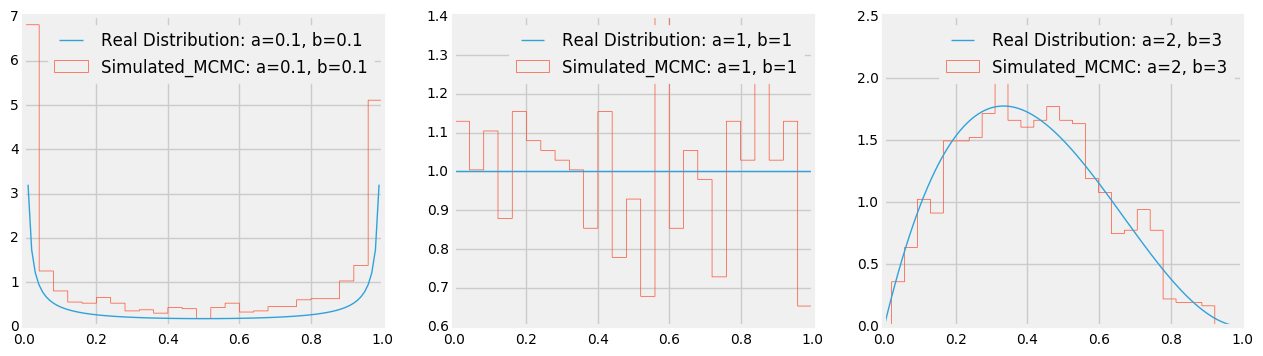

In [15]:
import numpy as np
import pylab as pl
import scipy.special as ss
%matplotlib inline
pl.rcParams['figure.figsize'] = (17.0, 4.0)

def beta_s(w,a,b):
    return w**(a-1)*(1-w)**(b-1)

# This Function returns True if the coin with probability P of heads comes heads when flipped.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

# This Function runs the MCMC chain for Beta Distribution.
def beta_mcmc(N_hops,a,b):
    states = []
    cur = random.uniform(0,1)
    for i in range(0,N_hops):
        states.append(cur)
        next = random.uniform(0,1)
        ap = min(beta_s(next,a,b)/beta_s(cur,a,b),1) # Calculate the acceptance probability
        if random_coin(ap):
            cur = next
    return states[-1000:] # Returns the last 100 states of the chain

# Actual Beta PDF.
def beta(a, b, i):
    e1 = ss.gamma(a + b)
    e2 = ss.gamma(a)
    e3 = ss.gamma(b)
    e4 = i ** (a - 1)
    e5 = (1 - i) ** (b - 1)
    return (e1/(e2*e3)) * e4 * e5

# Create a function to plot Actual Beta PDF with the Beta Sampled from MCMC Chain.
def plot_beta(a, b, n= None):
    if ( not n is None):
        plt.subplot(n)
    Ly = []
    Lx = []
    i_list = np.mgrid[0:1:100j]
    for i in i_list:
        Lx.append(i)
        Ly.append(beta(a, b, i))
    pl.plot(Lx, Ly, label="Real Distribution: a="+str(a)+", b="+str(b))
    pl.hist(beta_mcmc(100000,a,b),normed=True,bins =25, histtype='step',label="Simulated_MCMC: a="+str(a)+", b="+str(b))
    pl.legend()
    #pl.show()

plt.figure(figsize=(14,4))
plot_beta(0.1, 0.1,131)
plot_beta(1, 1,132)
plt.ylim((0.6,1.4))
plot_beta(2, 3, 133)

In [14]:
# AIM: To Decrypt a text using MCMC approach. i.e. find decryption key which we will call cipher from now on.
import string
import math
import random
# This function takes as input a decryption key and creates a dict for key where each letter in the decryption key
# maps to a alphabet For example if the decryption key is "DGHJKL...." this function will create a dict like {D:A,G:B,H:C....} 
def create_cipher_dict(cipher):
    cipher_dict = {}
    alphabet_list = list(string.ascii_uppercase)
    for i in range(len(cipher)):
        cipher_dict[alphabet_list[i]] = cipher[i]
    return cipher_dict

# This function takes a text and applies the cipher/key on the text and returns text.
def apply_cipher_on_text(text,cipher):
    cipher_dict = create_cipher_dict(cipher) 
    text = list(text)
    newtext = ""
    for elem in text:
        if elem.upper() in cipher_dict:
            newtext+=cipher_dict[elem.upper()]
        else:
            newtext+=" "
    return newtext

# This function takes as input a path to a long text and creates scoring_params dict which contains the 
# number of time each pair of alphabet appears together
# Ex. {'AB':234,'TH':2343,'CD':23 ..}
def create_scoring_params_dict(longtext_path):
    scoring_params = {}
    alphabet_list = list(string.ascii_uppercase)
    with open(longtext_path) as fp:
        for line in fp:
            data = list(line.strip())
            for i in range(len(data)-1):
                alpha_i = data[i].upper()
                alpha_j = data[i+1].upper()
                if alpha_i not in alphabet_list and alpha_i != " ":
                    alpha_i = " "
                if alpha_j not in alphabet_list and alpha_j != " ":
                    alpha_j = " "
                key = alpha_i+alpha_j
                if key in scoring_params:
                    scoring_params[key]+=1
                else:
                    scoring_params[key]=1
    return scoring_params

# This function takes as input a text and creates scoring_params dict which contains the 
# number of time each pair of alphabet appears together
# Ex. {'AB':234,'TH':2343,'CD':23 ..}

def score_params_on_cipher(text):
    scoring_params = {}
    alphabet_list = list(string.ascii_uppercase)
    data = list(text.strip())
    for i in range(len(data)-1):
        alpha_i =data[i].upper()
        alpha_j = data[i+1].upper()
        if alpha_i not in alphabet_list and alpha_i != " ":
            alpha_i = " "
        if alpha_j not in alphabet_list and alpha_j != " ":
            alpha_j = " "
        key = alpha_i+alpha_j
        if key in scoring_params:
            scoring_params[key]+=1
        else:
            scoring_params[key]=1
    return scoring_params

#create_scoring_params_dict("war_and_peace1.txt")

In [16]:
# This function takes the text to be decrypted and a cipher to score the cipher.
# This function returns the log(score) metric

def get_cipher_score(text,cipher,scoring_params):
    cipher_dict = create_cipher_dict(cipher)
    decrypted_text = apply_cipher_on_text(text,cipher)
    scored_f = score_params_on_cipher(decrypted_text)
    cipher_score = 0
    for k,v in scored_f.items():
        if k in scoring_params:
            cipher_score += v*math.log(scoring_params[k])
    return cipher_score

# Generate a proposal cipher by swapping letters at two random location
def generate_cipher(cipher):
    pos1 = random.randint(0, len(list(cipher))-1)
    pos2 = random.randint(0, len(list(cipher))-1)
    if pos1 == pos2:
        return generate_cipher(cipher)
    else:
        cipher = list(cipher)
        pos1_alpha = cipher[pos1]
        pos2_alpha = cipher[pos2]
        cipher[pos1] = pos2_alpha
        cipher[pos2] = pos1_alpha
        return "".join(cipher)

# Toss a random coin with robability of head p. If coin comes head return true else false.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True
    
# Takes as input a text to decrypt and runs a MCMC algorithm for n_iter. Returns the state having maximum score and also
# the last few states 
def MCMC_decrypt(n_iter,cipher_text,scoring_params):
    current_cipher = string.ascii_uppercase # Generate a random cipher to start
    state_keeper = set()
    best_state = ''
    score = 0
    for i in range(n_iter):
        state_keeper.add(current_cipher)
        proposed_cipher = generate_cipher(current_cipher)
        score_current_cipher = get_cipher_score(cipher_text,current_cipher,scoring_params)
        score_proposed_cipher = get_cipher_score(cipher_text,proposed_cipher,scoring_params)
        acceptance_probability = min(1,math.exp(score_proposed_cipher-score_current_cipher))
        if score_current_cipher>score:
            best_state = current_cipher
        if random_coin(acceptance_probability):
            current_cipher = proposed_cipher
        if i%500==0:
            print ("iter",i,":",apply_cipher_on_text(cipher_text,current_cipher)[0:99])
            
        #cipher_text = apply_cipher_on_text(cipher_text,current_cipher)
    return state_keeper,best_state

## Run the Main Program:

scoring_params = create_scoring_params_dict('war_and_peace1.txt')

plain_text = "As Oliver gave this first proof of the free and proper action of his lungs, \
the patchwork coverlet which was carelessly flung over the iron bedstead, rustled; \
the pale face of a young woman was raised feebly from the pillow; and a faint voice imperfectly \
articulated the words, Let me see the child, and die. \
The surgeon had been sitting with his face turned towards the fire: giving the palms of his hands a warm \
and a rub alternately. As the young woman spoke, he rose, and advancing to the bed's head, said, with more kindness \
than might have been expected of him: "

encryption_key = "XEBPROHYAUFTIDSJLKZMWVNGQC"
cipher_text = apply_cipher_on_text(plain_text,encryption_key)
decryption_key = "ICZNBKXGMPRQTWFDYEOLJVUAHS"

print("Text To Decode:", cipher_text, "\n")
states,best_state = MCMC_decrypt(20000,cipher_text,scoring_params)
#states,best_state = MCMC_decrypt(20000,plain_text,scoring_params)
print ("\nDecoded Text:",apply_cipher_on_text(cipher_text,best_state), "\n")
print ("MCMC KEY FOUND :",best_state)
print ("ACTUAL KEY USED:",decryption_key)

Text To Decode: XZ STAVRK HXVR MYAZ OAKZM JKSSO SO MYR OKRR XDP JKSJRK XBMASD SO YAZ TWDHZ  MYR JXMBYNSKF BSVRKTRM NYABY NXZ BXKRTRZZTQ OTWDH SVRK MYR AKSD ERPZMRXP  KWZMTRP  MYR JXTR OXBR SO X QSWDH NSIXD NXZ KXAZRP ORRETQ OKSI MYR JATTSN  XDP X OXADM VSABR AIJRKORBMTQ XKMABWTXMRP MYR NSKPZ  TRM IR ZRR MYR BYATP  XDP PAR  MYR ZWKHRSD YXP ERRD ZAMMADH NAMY YAZ OXBR MWKDRP MSNXKPZ MYR OAKR  HAVADH MYR JXTIZ SO YAZ YXDPZ X NXKI XDP X KWE XTMRKDXMRTQ  XZ MYR QSWDH NSIXD ZJSFR  YR KSZR  XDP XPVXDBADH MS MYR ERP Z YRXP  ZXAP  NAMY ISKR FADPDRZZ MYXD IAHYM YXVR ERRD RGJRBMRP SO YAI   

iter 0 : XZ STAVRK HXVR MYAZ OAKZM JKSSO SO MYR OKRR XDP JKSJRK XBMASD SO YAZ TWDHZ  MYR JXMBYNSKF BSVRKTRM 
iter 500 : ID ONCVEL YIVE ARCD FCLDA BLOOF OF ARE FLEE IHT BLOBEL IPACOH OF RCD NUHYD  ARE BIAPRWOLK POVELNEA 
iter 1000 : IS OLMVEC GIVE ARMS TMCSA HCOOT OT ARE TCEE IND HCOHEC IPAMON OT RMS LUNGS  ARE HIAPRWOCK POVECLEA 
iter 1500 : IS OLMVEC GIVE ARMS TMCSA HCOOT OT ARE TCEE IND HCOHEC IPAMON OT RMS 

### KNAP SACK Problem

In [ ]:
import numpy as np

W = [20,40,60,12,34,45,67,33,23,12,34,56,23,56]
G = [120,420,610,112,341,435,657,363,273,812,534,356,223,516]
W_max = 150

# This function takes a state X , The gold vector G and a Beta Value and return the Log of score
def score_state_log(X,G,Beta):
    return Beta*np.dot(X,G)

# This function takes as input a state X and the number of treasures M, The weight vector W and the maximum weight W_max
# and returns a proposal state
def create_proposal(X,W,W_max):
    M = len(W)
    random_index = random.randint(0,M-1)
    #print random_index
    proposal = list(X)
    proposal[random_index] = 1 - proposal[random_index]  #Toggle
    #print proposal
    if np.dot(proposal,W)<=W_max:
        return proposal
    else:
        return create_proposal(X,W,W_max)
    
# Takes as input a text to decrypt and runs a MCMC algorithm for n_iter. Returns the state having maximum score and also
# the last few states 
def MCMC_Golddigger(n_iter,W,G,W_max, Beta_start = 0.05, Beta_increments=.02):
    M = len(W)
    Beta = Beta_start
    current_X = [0]*M # We start with all 0's
    state_keeper = []
    best_state = ''
    score = 0
    
    for i in range(1,n_iter):
        state_keeper.append(current_X)
        proposed_X = create_proposal(current_X,W,W_max)

        score_current_X = score_state_log(current_X,G,Beta)
        score_proposed_X = score_state_log(proposed_X,G,Beta)
        
        #print( "Proposal is :" , str(proposed_X) , "W1: ", str(score_current_X), " W2: ", score_proposed_X, " Beta: ", Beta)
        
        acceptance_probability = min(1,math.exp(score_proposed_X-score_current_X))
        if score_current_X>score:
            best_state = current_X
        if random_coin(acceptance_probability):
            current_X = proposed_X
        if i%500==0:
            Beta += Beta_increments 
        # You can use these below two lines to tune value of Beta
        #if i%20==0:
        #    print "iter:",i," |Beta=",Beta," |Gold Value=",np.dot(current_X,G)
            
    return state_keeper,best_state

In [ ]:
max_state_value =0 
Solution_MCMC = [0]
Solution_Weight = 0;
for i in range(10):
    state_keeper,best_state = MCMC_Golddigger(50000,W,G,W_max,0.0005, .0005)
    state_value=np.dot(best_state,G)
    cweight = np.dot(best_state,W);
    print( "MCMC Intermediate is :" , str(Solution_MCMC) , "with Gold Value:", str(state_value), " Weight:", cweight)
    if state_value>max_state_value or (state_value == max_state_value and cweight < Solution_Weight):
        max_state_value = state_value
        Solution_MCMC = best_state
        Solution_Weight = cweight;

print( "MCMC Solution is :" , str(Solution_MCMC) , "with Gold Value:", str(max_state_value), " Weight: ", Solution_Weight)


### This is a sample from http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/


In [ ]:

import matplotlib as mpl
label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['xtick.labelsize'] = 5

''

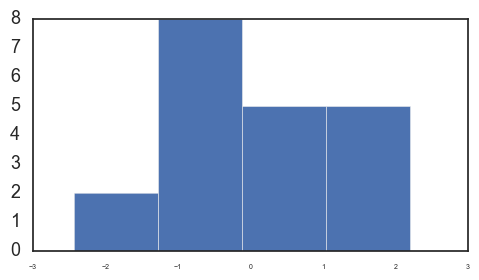

In [17]:
import scipy as sp
import seaborn as sns
from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

#plt.figure(figsize=(4,3) )
#matplotlib.rcParams['figure.figsize'] = (5,3)
plt.figure(figsize=(5,3))
plt.rc('font', size=7)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.color'] = 'r'
plt.rcParams['xtick.labelsize'] = 5


np.random.seed(123)
data = np.random.randn(20)
plt.hist(data, bins=4)
;

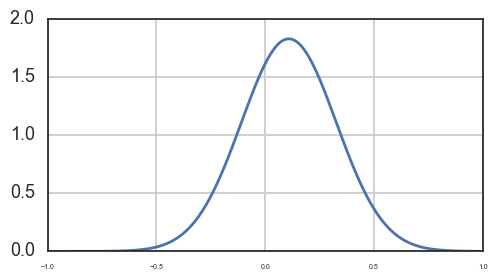

In [18]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

plt.figure(figsize=(5,3))

#ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
plt.plot(x, posterior_analytical)
#ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
#sns.despine()
plt.grid(True)


##PYMC examples

In [2]:
#Basics

#n=pymc.Normal('Operating Cost', mu=15000, tau=1/(1000*1000) )
#n=pymc.Normal('Operating Cost', mu=0, tau=1)
#vs = [n.random() for i in range(1000) ]
#plt.hist(vs);
